# IMPOR DATASET DAN PREPROCESSING

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade xgboost
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import string
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split, learning_curve
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, DMatrix, train
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
stopwords = pd.read_csv('/content/drive/MyDrive/local_languages_stopwords.csv')
dataset = pd.read_excel('/content/drive/MyDrive/BARU_gabungan_dataset.xlsx')

In [ ]:
dataset['class'].value_counts()

,count
class,
5,168
10,147
9,69
1,60
6,48
3,38
4,28
7,19
2,13


In [ ]:
stopwords = [word.lower() for word in stopwords['javanese']]
stopwords

['ana',
 'yaiku',
 'orane',
 'kangge',
 'luwih',
 'dianggo',
 'dadi ngono',
 'bakal',
 'bakal',
 'pungkasan',
 'pungkasan',
 'pungkasane',
 'aku',
 'kula',
 'banget',
 'banget',
 'sampeyan',
 'sampeyan',
 'antarane',
 'antarane',
 'antarane wong-wong mau',
 'apa',
 'apa',
 'yen',
 'yaiku',
 'utamane',
 'akatah',
 'tegese',
 'asal',
 'diwenehake',
 'ing',
 'utawa',
 'utawa iku',
 'utawa',
 'diwiwiti',
 'wiwitane',
 'kaya',
 'kaya',
 'kepiye',
 'kepiye',
 'nanging',
 'kanggo',
 'bagean',
 'malah',
 'iku',
 'iku',
 'apik',
 'bakal',
 'arep',
 'teka maneh',
 'akeh',
 'rama',
 'anyar',
 'ngisor',
 'nomer saka',
 'katon',
 'iki',
 'kajaba iku',
 'iki carane',
 'dadi',
 'kajaba iku',
 'iku iku',
 'kajaba iku',
 'nyambut gawe',
 'konco',
 'mengko',
 'durung',
 'durung',
 'bener',
 'iku bener',
 'bener',
 'ana ing',
 'pungkasan',
 'pungkasan',
 'rampung',
 'wonten pinten',
 'apa',
 'apa sing sampeyan lakoni',
 'apa wae',
 'tegese',
 'miwiti',
 'macem-macem',
 'tiba',
 'menehi',
 'menehi',
 'dip

In [ ]:
char_mapping = {
    "â": "a",
    "ê": "e",
    "é": "e",
    "è": "e",
    "ô": "o",
    "ù": "u",
    "î": "i",
    "ï": "i",
    "dh": "d",
    "th": "t",
    "kh": "k",
    "ngg": "ng",
    "ny": "n",
    "sj": "s",
    "tj": "c",
    "dj": "j",
    "ḍ": "d",
    "ḥ": "h",
    "ṭ": "t",
    "ś": "s",
    "ṣ": "s",
    "ŋ": "ng",
    "ā": "a",
    "ū": "u",
    "[": "",
    "]": "",
    "*": "",
    "...": ",",
}

prefixes = ["ang", "pang", "pan", "ke", "di", "ka", "pa", "sa", "dak", "tak", "a"]
suffixes = ["ipunipun", "ipun", "an", "na", "a", "i", "mu", "ku"]
infixes = ["um", "in", "ar", "al", "ah", "as", "ra"]
confixes = [("ang", "an"), ("pang", "an"), ("di", "i"), ("ke", "an"), ("ka", "an"),
            ("pa", "an"), ("sa", "an"), ("tar", "an"), ("a", "an")]


In [ ]:
from dataclasses import dataclass, field
from typing import Dict

# Definisi struktur Trie
@dataclass
class TrieNode:
    children: Dict[str, 'TrieNode'] = field(default_factory=dict)
    is_end: bool = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end = True

    def match_prefix(self, word):
        node = self.root
        for i, char in enumerate(word):
            if char not in node.children:
                return None
            node = node.children[char]
            if node.is_end:
                return word[:i+1]
        return None

    def match_suffix(self, word):
        node = self.root
        for i, char in enumerate(reversed(word)):
            if char not in node.children:
                return None
            node = node.children[char]
            if node.is_end:
                return word[-(i+1):]
        return None

def remove_with_trie(word, trie, is_prefix=True):
    if is_prefix:
        match = trie.match_prefix(word)
        if match:
            return word[len(match):]
    else:
        match = trie.match_suffix(word)
        if match:
            return word[:-len(match)]
    return word

prefix_trie = Trie()
suffix_trie = Trie()
for prefix in prefixes:
    prefix_trie.insert(prefix)
for suffix in suffixes:
    suffix_trie.insert(suffix)

# Proses stemming
def optimized_stem_word(word):
    word = remove_with_trie(word, prefix_trie, is_prefix=True)
    word = remove_with_trie(word, suffix_trie, is_prefix=False)
    return word

In [ ]:
def apply_char_mapping(text):
    for original, replacement in char_mapping.items():
        text = text.replace(original, replacement)
    return text
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = apply_char_mapping(text)
    words = word_tokenize(text)
    words = remove_stopwords(words)
    words = [optimized_stem_word(word) for word in words if word not in stopwords]
    return words
dataset['processed_text'] = dataset['text'].apply(preprocess_text)

Preprocessing ini dilakukan dengan menghilangkan stopwords, menghilangkan punctuation, tokenisasi, dan stemming.

In [ ]:
dataset

,text,class,processed_text
0,"Bab Alakirabi, Wayuh kalihan Botên\nKaranganip...",1,"[bab, lakirab, wayuh, lih, boten, ranganipun, ..."
1,Vorkortingen\nK.L. : Kêmbang Lampir | K.G. : K...,1,"[vorkortingen, kl, mbang, lampir, kg, kut, ged..."
2,"[NA]\nNa :\n1 na, sa, da, ta, aksara untu\n2 n...",1,"[n, n, 1, n, , d, t, ksar, untu, 2, n, n, m, n..."
3,"[CA]\nCa :\nwanci, sukci\nPasangan Ca gêdhe in...",1,"[c, c, wanc, sukc, sang, c, gede, ingar, sang,..."
4,"[RA]\nRa :\n1. ra, la, dha, tha, aksara ilat.\...",1,"[r, r, 1, r, l, d, t, ksar, ilat, 2, r, ksar, ..."
...,...,...,...
596,Warnasari\n--- [0] ---\n\nCandraning warna ......,9,"[warnasar, 0, candraning, warn, blz, 1, căndra..."
597,Sêrat Wasitabasa[1]\n--- 302 ---\n\nWasitabasa...,9,"[serat, wasitabasa1, 302, wasitabas, ngabe, iv..."
598,Wawaton panyêratipoen têmboeng Jawi mawi sastr...,9,"[wawaton, neratipoen, temboeng, jaw, maw, str,..."
599,Wulang Basa\nKangggo ing pangkat 3.\n\nAnggita...,9,"[wulang, bas, ngkat, 3, ngitane, mas, stradiar..."


# DOC2VEC DEPLOYMENT

In [ ]:
tagged_documents = [
    TaggedDocument(words=row['processed_text'], tags=[str(row['class'])])
    for _, row in dataset.iterrows()
]

In [ ]:
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
y = [doc.tags[0] for doc in tagged_documents]
for i in range(10):
    print(y.count(str(i+1)))

60
13
38
28
168
48
19
11
69
147


In [ ]:
x = [doc2vec_model.infer_vector(doc.words) for doc in tagged_documents]
y = [doc.tags[0] for doc in tagged_documents]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
x

[array([-3.219707  , -2.8520324 ,  0.3009883 ,  2.6469214 ,  4.089383  ,
        -1.9128051 ,  0.17075503, -3.5906641 , -3.6889985 , -1.3228668 ,
         3.512195  , -5.3479786 , -0.86953646,  3.6795802 , -3.8926933 ,
        -1.1426193 ,  0.8382453 ,  5.8918896 , -4.1230435 ,  3.2223196 ,
        -2.5474465 ,  3.0362864 , -3.7699354 ,  0.4634006 ,  4.802451  ,
        -1.8112631 , -2.11015   , -7.616797  ,  2.4269912 , -2.0255594 ,
         2.7808409 ,  2.7994232 ,  0.2699612 , -0.24213763,  0.17689076,
         1.1822697 ,  2.3248518 , -3.7174876 ,  5.183299  , -5.2829137 ,
         0.85595083, -2.5511084 , -1.3087244 ,  0.5787898 ,  4.922713  ,
         2.2408211 , -0.66781193, -2.3330336 ,  2.2992914 , -2.8142984 ,
         0.28212792, -4.17348   ,  1.8962331 ,  0.0437673 , -1.537017  ,
         4.0835776 ,  2.6435432 ,  0.24543479, -1.3213985 ,  0.8495749 ,
        -3.2701423 ,  0.6255387 , -0.956127  , -1.220849  , -3.3957047 ,
        -0.3898608 ,  2.6021428 , -1.697764  ,  4.2

# MODEL DEPLOYMENT

In [ ]:
y_train = [int(iter)-1 for iter in y_train]
y_test = [int(iter)-1 for iter in y_test]

[0,
 3,
 4,
 9,
 5,
 9,
 9,
 3,
 0,
 2,
 9,
 4,
 9,
 4,
 9,
 9,
 4,
 9,
 5,
 4,
 2,
 4,
 9,
 6,
 4,
 4,
 7,
 4,
 1,
 4,
 6,
 4,
 8,
 4,
 8,
 4,
 0,
 3,
 8,
 9,
 4,
 2,
 4,
 9,
 6,
 8,
 4,
 2,
 4,
 8,
 4,
 9,
 7,
 9,
 4,
 4,
 9,
 5,
 3,
 9,
 8,
 9,
 4,
 4,
 5,
 8,
 4,
 4,
 9,
 9,
 9,
 4,
 9,
 5,
 4,
 0,
 2,
 2,
 8,
 2,
 3,
 4,
 4,
 9,
 9,
 1,
 1,
 0,
 9,
 4,
 4,
 5,
 4,
 9,
 5,
 9,
 4,
 9,
 0,
 0,
 2,
 9,
 4,
 4,
 3,
 2,
 4,
 5,
 9,
 9,
 8,
 4,
 4,
 9,
 4,
 4,
 5,
 2,
 9,
 5,
 8,
 8,
 9,
 9,
 1,
 4,
 9,
 9,
 5,
 9,
 4,
 9,
 8,
 1,
 4,
 9,
 8,
 0,
 0,
 9,
 9,
 9,
 4,
 4,
 9,
 4,
 3,
 0,
 4,
 4,
 4,
 9,
 0,
 4,
 5,
 9,
 9,
 6,
 8,
 9,
 0,
 4,
 3,
 4,
 8,
 4,
 8,
 7,
 8,
 2,
 9,
 4,
 9,
 8,
 0,
 4,
 0,
 6,
 4,
 9,
 0,
 4,
 4,
 4,
 0,
 8,
 0,
 0,
 8,
 4,
 4,
 0,
 8,
 9,
 2,
 2,
 6,
 5,
 9,
 9,
 8,
 7,
 8,
 4,
 9,
 3,
 2,
 4,
 9,
 8,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 9,
 9,
 9,
 3,
 9,
 5,
 0,
 9,
 4,
 0,
 3,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 8,
 6,
 0,
 4,
 8,
 9,
 3,
 8,
 0,
 5,
 4,
 5,
 9,


In [ ]:
pd.Series(y_train).value_counts()

,count
4,134
9,118
8,55
0,48
5,38
2,30
3,22
6,15
1,11
7,9


In [ ]:
dtrain = DMatrix(x_train, label=y_train)
dtest = DMatrix(x_test, label=y_test)
params = {
    "objective": "multi:softmax",
    "num_class": 10,
    "learning_rate": 0.1,
    "max_depth": 6,
    "eval_metric": "mlogloss",
    "seed": 42,
    "lambda": 1.051,
    "alpha": 0.185
}
evals_result = {}
model = train(params, dtrain, num_boost_round=200, evals=[(dtrain, "train"), (dtest, "validation")], evals_result=evals_result, verbose_eval=True)

[0]	train-mlogloss:1.90538	validation-mlogloss:1.94253
[1]	train-mlogloss:1.63691	validation-mlogloss:1.70862
[2]	train-mlogloss:1.42968	validation-mlogloss:1.53013
[3]	train-mlogloss:1.26101	validation-mlogloss:1.38019
[4]	train-mlogloss:1.12126	validation-mlogloss:1.25574
[5]	train-mlogloss:1.00292	validation-mlogloss:1.14865
[6]	train-mlogloss:0.90116	validation-mlogloss:1.05567
[7]	train-mlogloss:0.81185	validation-mlogloss:0.97540
[8]	train-mlogloss:0.73231	validation-mlogloss:0.90224
[9]	train-mlogloss:0.66213	validation-mlogloss:0.83723
[10]	train-mlogloss:0.59972	validation-mlogloss:0.77898
[11]	train-mlogloss:0.54402	validation-mlogloss:0.72735
[12]	train-mlogloss:0.49444	validation-mlogloss:0.68159
[13]	train-mlogloss:0.44971	validation-mlogloss:0.63990
[14]	train-mlogloss:0.40935	validation-mlogloss:0.60200
[15]	train-mlogloss:0.37335	validation-mlogloss:0.56519
[16]	train-mlogloss:0.34073	validation-mlogloss:0.52981
[17]	train-mlogloss:0.31121	validation-mlogloss:0.50044
[1

In [ ]:
validation_logloss = evals_result["validation"]["mlogloss"]
train_logloss = evals_result["train"]["mlogloss"]

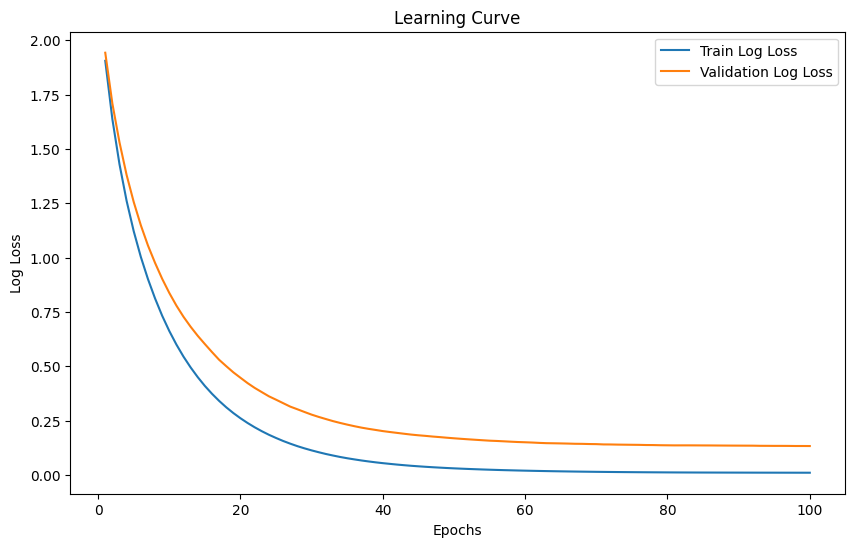

In [ ]:
epochs = range(1, len(train_logloss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_logloss, label="Train Log Loss")
plt.plot(epochs, validation_logloss, label="Validation Log Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(dtest)

# HASIL EVALUASI MODEL

In [ ]:
report = classification_report(y_test, y_pred, target_names=['Adat dan Tradisi', 'Bacaan Huruf Jawa', 'Gending dan Notasi', 'Kagunan', 'Kamus dan Leksikon', 'Karawitan', 'Panembrama dan Iber', 'Pawukon dan Primbon',
                                                            'Pengatahuan bahasa', 'Wayang'], output_dict=True)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score: ", report['macro avg']['f1-score'])
print("Precision: ", report['macro avg']['precision'])
print("Classification Report:\n",
      classification_report(
          y_test, y_pred,
          labels=np.unique(y_test),
         target_names=['Adat dan Tradisi', 'Bacaan Huruf Jawa', 'Gending dan Notasi', 'Kagunan', 'Kamus dan Leksikon', 'Karawitan', 'Panembrama dan Iber', 'Pawukon dan Primbon',
                                                            'Pengatahuan bahasa', 'Wayang']
      ))

Accuracy: 0.9586776859504132
F1-Score:  0.9002009616106978
Precision:  0.8993295019157088
Classification Report:
                      precision    recall  f1-score   support

   Adat dan Tradisi       1.00      1.00      1.00        12
  Bacaan Huruf Jawa       0.50      0.50      0.50         2
 Gending dan Notasi       0.78      0.88      0.82         8
            Kagunan       1.00      1.00      1.00         6
 Kamus dan Leksikon       1.00      1.00      1.00        34
          Karawitan       1.00      1.00      1.00        10
Panembrama dan Iber       0.75      0.75      0.75         4
Pawukon dan Primbon       1.00      1.00      1.00         2
 Pengatahuan bahasa       1.00      0.93      0.96        14
             Wayang       0.97      0.97      0.97        29

           accuracy                           0.96       121
          macro avg       0.90      0.90      0.90       121
       weighted avg       0.96      0.96      0.96       121



# VISUALISASI EVALUASI HASIL MODEL

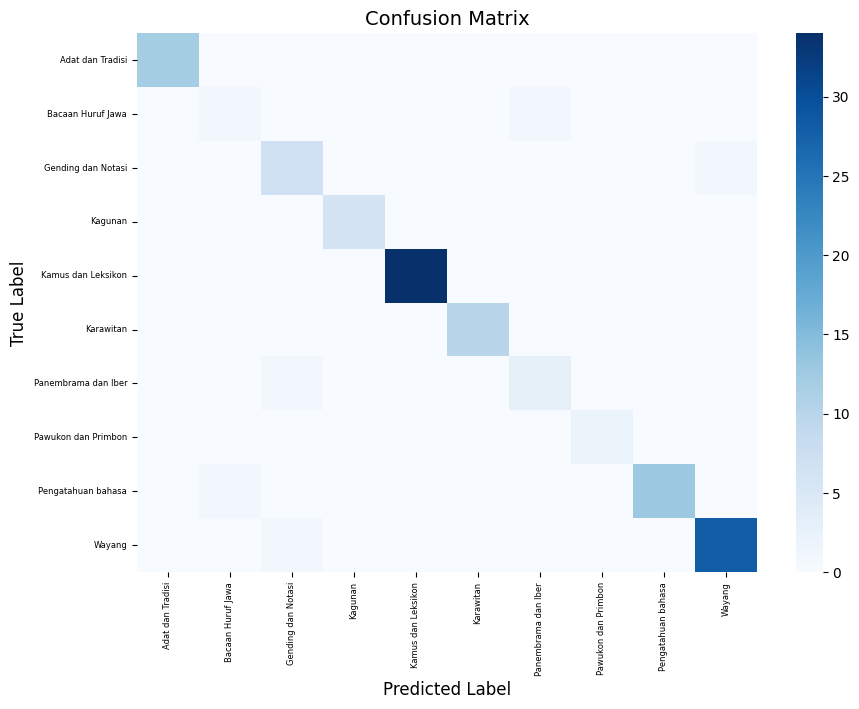

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, cmap='Blues', cbar=True, xticklabels=['Adat dan Tradisi', 'Bacaan Huruf Jawa', 'Gending dan Notasi', 'Kagunan', 'Kamus dan Leksikon', 'Karawitan', 'Panembrama dan Iber', 'Pawukon dan Primbon',
                                                            'Pengatahuan bahasa', 'Wayang'], yticklabels=['Adat dan Tradisi', 'Bacaan Huruf Jawa', 'Gending dan Notasi', 'Kagunan', 'Kamus dan Leksikon', 'Karawitan', 'Panembrama dan Iber', 'Pawukon dan Primbon',
                                                            'Pengatahuan bahasa', 'Wayang'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.show()


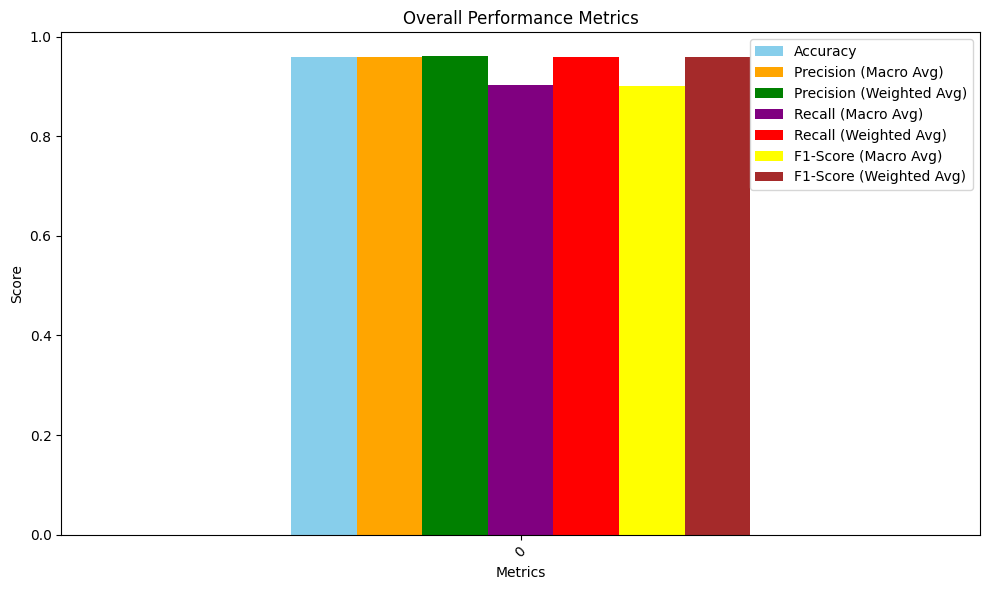

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_test, y_pred)

overall_report = {
    'Accuracy': accuracy,
    'Precision (Macro Avg)': report['accuracy'],
    'Precision (Weighted Avg)': report['weighted avg']['precision'],
    'Recall (Macro Avg)': report['macro avg']['recall'],
    'Recall (Weighted Avg)': report['weighted avg']['recall'],
    'F1-Score (Macro Avg)': report['macro avg']['f1-score'],
    'F1-Score (Weighted Avg)': report['weighted avg']['f1-score']
}

overall_df = pd.DataFrame(overall_report, index=[0])


overall_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green', 'purple', 'red', 'yellow', 'brown'])
plt.title('Overall Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# MESIN UNTUK PREDICT SUATU GENRE DARI INPUTAN CERITA

In [ ]:
def predict_genre(input_text, doc2vec_model, xgb_model):

    processed_words = preprocess_text(input_text)

    vector = doc2vec_model.infer_vector(processed_words)

    dinput = DMatrix(vector.reshape(-1,1))
    target_names=['Adat dan Tradisi', 'Bacaan Huruf Jawa', 'Gending dan Notasi', 'Kagunan', 'Kamus dan Leksikon', 'Karawitan', 'Panembrama dan Iber', 'Pawukon dan Primbon',
                                                            'Pengatahuan bahasa', 'Wayang']
    prediction = target_names[int(xgb_model.predict(dinput)[0])]

    return prediction


In [ ]:
# Sebuah contoh inputan dimana label asli adalah KAMUS DAN LEKSIKON
# Kita cek apakah model dapat memprediksi dengan benar atau tidak

input_text = '''
[...antaranya)] ing dalêm, ing sajroning; 3 cat, up. antara kelihatan dengan tiada (cat katon cat ora); mengantara: nêngahi ut. misah; pengantara: pamisah, wong kang dadi dalan; pengantaraan: panglantar, lantaran.anterosakabèhe, sakèhe.antelaskêsting.antianti (mungsuh).antingbatu anting: bandhul ing jangkar lsp.; anting-anting: 1 anting-anting; 2 bandhul; menganting: gumandhul geyong-geyong.antuiantoi, bngs. wit kênanga.antukmengantuk: 1 ngantuk; 2 (ut. berantuk) natab, njêglug, nyandhung; terantuk: kêsandhung, kêtatap.antulmengantul: mêndal.antunbêsus, sarwa bêcik; berantun: macak, dandan.antupêntup; kc. sengat.anuanu.anunanu.anugerahpêparing, ganjaran; dianugerahi: diganjar.anumanom.anurkc. andur.anutmenganut: manut, mèlu, miturut; penganut: wong kang miturut salah sawijining panêmu ut. agama.anyamdianyam: diênam; anyaman: nam-naman.anyangbngs. gêcok iwak mêntah.anyiramis.apaapa; barang apa, segala apa: samubarang; tiada apa (mengapa): ora apa-apa; apalah: mbok iya ... ; mengapa: ana ngapa, geneya, sabab apa; di(peng)apakan, di(peng)apai: dikapakake.apabilakapan, besuk apa, samangsa.apakapêk, pênguk.apakalakapan, samangsa.apalapal.apalagiapamanèh, luwih-luwih.apamapêm.apam dewasêmanggi gunung.apasluwês sarta cèkli.apigêni; berapi: mêtu gênine, murub; perapian: prapèn, kêrên.api-apikonang.apikapik, bêcik.apil(an)kayu têtamèng prau ingarêp.apiunapyun, candu.apitut. terapit: kêjêpit, kêpèpèd; berapit: pèpèd-pèpèdan; diapit: dijêpit, diplèpèd; pengapit: gapit, jêpitan; apitan: pamipitan, piranti dianggo mlèpèd.apungbarang kang kumambang; apung-apung; kambang; mengapung: kambang-kambang; terapung: kumambang.arabngs. wringin.arafgêni pangrêsikan ing ngakerat.arahênêr; arah ke-: kêpering ing, pênêr ing; mengarah: ngênêr; diarahkan: diênêrake, ditujokake.arakI berarak: arak-arakan; diarak: diarak; perarakan: arak-arakan. II ut. 'arak: arak.arakiannuli, banjur.'aralaral, alangan.aramdiaram: diulat-ulatake marga disujanani; diincim-incim.aram-aramjlagrag kêna diêlah-êlih, sêtègêr.aram-temaransurêm (rêmbulan lsp.).arangarêng.arang batuarêng batu.arang para-paraangus.arasI awas ratumu (ing dolanan catur). II pêrês; mengaras: mêrês.araskerdanar. panganan.'arasydhamparing Pangeran.araudiarau: diubak, diudhak, dikêbur.Arba'Rêbo.arcarêca.arikulit ari: kulit ayam; ular ari: ar. ula mandi.'arifsarjana, wong pintêr, wicaksana.aringI mambu sumêgrak, pêsing. II kêmbang kacang (peranganing kêris).ariparip, ngantuk.arisI tali aris: tampar ut. pênjalin ditrap ing pinggiraning layar lsp. II tlutuh garing.arittumuli, banjur.arkaringkih.arkiantumuli, banjur.arkustruwèlu.arlojijam.
--- 15 ---

armadaprau-prau pêrang.arnabtruwèlu.artitêgês, maksud; mengarti, mengerti: ngrêti; berarti: atêgês; tiada berarti: tanpa têgês, ora sapiraa; diartikan: ditêgêsi, ditêrangake; pengertian: pangrêti, têgês.arudainggu.arukmengaruk: njogèd ngaturake kasêtyan lsp.arundiarun: dikaru, diulêd lan diublak.arungdiarung (i): disabrangi, diambah ngrubyuk; arungan: sabrangan, sagara kang diambah prau.arusilining banyu (ombak).arwah1 roh, jiwane wong sing wis ajal; 2 (ut. makan arwah) slamêtan mêmule wong sing wis ajal; diarwahkan: dimêmule tmr. wong ajal.asindhèn, negeri as: Nippon-Jerman-Itali.asapangarêp-arêp; putus (hilang) asa: êntèk pangarêp-arêpe; asa-asaan: tansah ngarêp-arêp kapriye kadadeyane.'asabaturat, saraf.asabatwarisan, pusaka.asadsinga.asahdiasah: diasah, digosok murih landhêp.asahanpinggan gêdhe.asaipadha popol; mengasai: popol, bubukên.asakberasak-asak: jêjêl riyêl, ndhêsuk; diasak: dijêjêl, diênêt-ênêt, dipadhêtake.asalI asal, asli, pinangka; berasal: asal saka, isih darah. II ut. asalkan: waton, anggêr, sok uga.asaliasli.asal-usulwêwaton, mula bukane, asal-usul.asam1 kêcut; 2 asêm; diasam(kan): diasêmi, dikum lsp. ing kêkêcut; asaman: kêkêcut.asapkêbul, kukus; berasap: kumukus, kêbul-kêbul; diasap(i): dikêbuli, dikutugi, dikukusi.'asarwayah sêmbahyang asar.asastêtalês, dhêdhasar, wêwaton.asiI bênêr, cocog. II mbalela; ora miturut.asik1 (ut. 'asik, 'asyik) kêsêngsêm, kêtungkul; 2 rongèh, ora jênjêm.asinasin; diasinkan: diasin, dikamal.asing1 nylênèh, ndhewe, ora padha karo panunggalane; 2 ngamanca; 3 anèh; diasingkan: didhèwèkake, disingkirake, dibuwang adoh; terasing: mênjila, kêpêncil.'askarwadyabala.asliasli, isih darah.asmaasma; jênêng.asmarasih, kasêngsêman.asomengaso: ngaso.asrama1 pratapan; 2 omah pamondhokan (kanggo bocah sêkolah lsp.).asrarwinadi.astakabalai astaka: bale palênggahan.astakonamaju wolu, maju akèh.astana, istanakêdhaton, kraton.asuhdiasuh: diêmong; pêngasuh: pamomong; asuhan: momongan, ênggone ngêmong.asungdiasung: diajani; kc. asut.asutdiasut: diojok-ojoki, diajani, digêgasah; pengasut: wong kang ngojok-ojoki; asutan: pangojok-ojok.aswadirêng.'asyikkc. asik.'asyuratanggal sapuluh sasi Muharam (Sura).atalatal.atapatêp, payon.'atarar. lênga wangi ut. ombèn-ombèn.atas1 (dari,- di-, kê-) (saka, ing, mênyang) ndhuwur; 2 mungguh ing, up. atas hal ini; 3 atas, têrang saka, up. atas perintah raja; 4 marang, ing, up. menimpa atas dirinya; 5 dadi, up. dibagi atas lima bahagi; 6 kêdadeyan saka, up terjadi atas lima sebab; 7 tumrap, dadi bubuhane, up. pembayaran ini atas hambalah; 8 wêwaton (miturut) saka, up. atas syari'at Nabi Isa; beratas-atasan: rêbut unggul; mengatas: munggah, ngatas; diatasi: diungkuli.atas anginngatas angin.atauutawa.atmasukma.atungI mengatung: kumambang kampul-kampul, mabur kêkêjêr up. kupu. II udang atung: ar urang.
--- 16 ---

aturI beratur, teratur: tata, ajêg, tumata; diatur: ditata, dipranata; aturan: tatanan, pranatan, rêrigên; peraturan: pranatan. II diaturi: diaturi; diaturkan: diaturake; katur.'auliauliya, wong suci.aummengaum: nggêro.aurpring ori.'aurat1 wuda, 2 urat (wêwadi).ausgêrang, padha gripis.awaicuwa, gêla, kagol.awak1 awak, badan; 2 (-kapal, -pêrahu) bêbauning prau; 3 (-ku, -mu, nya) aku, kowe, dhèwèke.awalawal, wiwitan, kang dhisik; awalan: atêr-atêr.awan1 mega, mêndhung; 2 kanggo jênênging ukir-ukiran ut. gêgambaran warna-warna kyt. awan bêrarak, awan mêlarat lsp; berawan: mêndhung, kasaput ing mega; mengawan: munggah ing awang-awang.awangthole, ênggèr.awang-awang(an), awang gemawangawang-awang.awasawas, prayitna; diawasi: ditamatake, diawat-awati; dibawah pengawasan: diulat-ulatake.awinpengawinan: (wong kang nggawa) tumbak upacara.awitawèt.ayahrama (bapa).ayahandaingkang rama.ayak(ut. pengayakan): ayakan, kalo saringan; mengayak: megol-megol, mlêndhung tmr. layar; diayak: diayaki.ayak-ayakninitèh.ayalgojag-gajêg, manggamara.ayampitik; ayam betina: babon; ayam jantan: jago.ayam-ayamanmanuk sribombok.ayam-hutan, ayam berogaayam alas.ayanblêg.ayang-ayangar. tamba (jamu).ayapandhaharing ratu, cadhong.ayarbanyu.ayatayat (peranganing bab).ayoayuh, ayo.ayumdiayum: dirojongi lan dibiyantu.ayunberayun, mengayun: 1 mbandul, obah geyong-geyong; 2 lingsir (tmr. srêngenge ± jam 4); ayunan: bandulan.ayun-temayunwayah lingsir (jam 4 sore).'azabsiksaning Pangeran.azadtanpa cacad.azal, azalilanggêng (tanpa kawitan).'azanadan.azasniyat, sêdya (sok kliru karo asas).'azimatjimat.azulwiwit biyèn mula.
B
ba'kaya.bab1 gapura; 2 bab.babababah.babadbabad.babakbabak (ing crita lsp).babangut. terbabang: mênga amba, mlowoh.babar1 jumèrèng; 2 babar, ora kêmpêl; dibabar: dibèbèr, dijèrèng.babasut. terbabas: suwèk pating sluwir tmr. layar, kentas bablas, bubrah mawut tmr. barisan.babattimbang, babag, rêrakitan.babibabi; membabi buta: nekad.babi duyungiwak dhuyung.babi hutancèlèng.babilmbrêngkêlo, ora manutan.babi rusabngs. cèlèng nganggo siyung munggah.babitdibabit: disangkut ut. dikatutake ing prakara.babubabu.babu susu (-tetek)inya.babu keringbabu rêrêsik.babu cucibabu ngumbahi.babukgêblêg, mbocahi.bacadibaca: 1 diwaca; 2 diucapake tmr. lapal lsp.
--- 17 ---

bacarbocor (kêrêp omong).bacinbacin.bacul(wong kang) ngêpluk, jirih.bacokdibacok: dibacok, disuduk.badaiprahara gêdhe.ba'dabakda, sawise.ba'dahusawise iku.badakwarak.badamI woh amandêl. II bunga badam: trutul abang ing kulit.badan1 badan awak, awak-awak, gêmbung; 2 bêbadan; badan pengarang: bêbadan juru ngarang.badangbngs. kalo gêdhe.badarI rêmbulan purnama (ent. endah). II wadêr, badhèr.badiilu lsp. kang njalari lêlara, dayaning lêlêmbut.badikbngs. wêdhung cilik.badukgêdhe mbêmbêng.badungbadhong.badutbadhut.baftablacu.bagai1 jinis; 2 (ut. sebagai) kaya, padha karo; (ber) bagai-bagai: warna-warna; tiada terbagaikan: tanpa upama.bagai-lagi (-pula)mêngkono uga.bagaimanakapriye.bagalI gagang manggar. II gêdhe gothot tmr. jago lsp. III bihal.bagan1 cêngkoronganing omah lsp; 2 tilas omah lsp; 3 omah tambêl (palerenan lsp), omah ing babagan (pêlabuhan) 4 rengrengan.bagar1 bangka; 2 wangkod; kc. begar.bagasgothot kiyêng tmr. pawakan, bakuh tmr. barang dandanan, groboh tmr. gêgarapan, bantêr tmr. angin.bagatbngs. wit arèn.bagiI tumrap ing, kanggo ing. II perangan: kc. bahagi.bagiabêgja; kc. bahagia.bagindaSang Prabu.bagurgêdhe dhuwur.bagusbagus, bêcik.bahbanjir, lubèr, wrata sumêbar.bahadurikêndêl bangêt.bahagiut. bahagian: bageyan, perangan, panduman; dibahagi: diperang, dibage, didum; dibahagikan: didum-dum, didum-dumake.bahagiabêgja, kabêgjan.bahayabêbaya; berbahaya: mbêbayani.bahaya airkêbanjiran.bahaya apikobongan.bahamdibaham: dimamah mingkêm.bahan1 sigaran kayu lsp. bakal balungan omah lsp; 2 barang-barang bêbakaling dandanan, guru bakal: dibahan: 1 didhodhogi, ditêbak-têbak tmr. lawang lsp; 2 disigari ut. diprèjèngi tmr. kayu.bahanaswara ngumandhang sêru.bahang (-api)sumuking gêni, urubing gêni.baharsêgara.bahara1 ar. bobot; 2 awak-awaking prau; tolak bahara: momotan dianggo ngêbot-êboti supaya aja nggoling.bahariI wong palayaran. II ing pantun owah-owahane têmbung baharu. III 1 endah, bêcik; 2 pantês pinundhi-pundhi.baharu, baru1 anyar; 2 lagi, mêntas bae; dibaharui: dianyarake, dibangun anyar.bahasI dibahas: dirapêtake tmr. kayu rênggang lsp. II panitipriksa: 'ilmu bahas: kawruh bab bêbantahan; berbahas: bawarasa, bêbantahan, srasehan.bahasa, basaI 1 basa, têtêmbungan; 2 tatakrama; 3 sarèh, alus; 4 sêmu, rada, up. gila-gila bahasa (rada edan); berbahasa: 1 migunakake basa: 2 ngrêti tatakrama; dibahasakan: ditêmbungake, dibasakake perbahasa(an): paribasan. II yèn, bilih.bahatsebahat, rukun, mupakat.bahkan1 kasinggihan, iya; 2 malah iya, malahan.bahupundhak.bahteraprau.bahwa1 anadene; 2 yèn, bilih.bahwasanya1 mungguh ing satêmêne; 2 anadene.ba'id(sanak) adoh; karib dan ba'id: sanak cêdhak lan adoh.baiduriintên widuri.baikbêcik, prayoha, pantês; baik ... , baik [ba...]
--- 18 ---

[...ik] (ut. ataupun, maupun) ...; sanajana ... ewadene; iya ... iya ...; dibaiki: 1 dibêciki, diupakara; 2 (ut. dibaikkan, diperbaiki) didandani, dibênakake, dibênêrake.baitkidungan, rêrêpèn.baitu'lharamomah suci (mêsjid Mêkah).baitu'lmalgêdhong rajabrana.baitu'lmukaddis(omah suci) Yèrusalèm.bajaI besi baja: waja. II banyon. III rabuk: dibaja(kan): dirabuki.bajakI wluku; dibajak: diwluku; II bajag.bajanwadhah (tong, èncèh lsp).bajangI ar. mêmêdi awujud rase: gelang bajang: gêlang lawe sutra irêng dianggo têtulak. II kayu cathokan ing sambungan.bajang-bajangar. wiji sukêt.bajauar. bangsa ing Borneo lan Sèlèbês kulon.bajipaju.baji-bajiar. iwak sêgara.bajikkebajikan: kabêcikan, kautaman.bajingbajing; kc. tupai.bajinganbajingan; kc. copèt.bajuklambi.baju besikêre wêsi.baju dalamklambi rangkêpan.baju kurungklambi kurung.bakrob ing sagara.bakaI wêwatakan, kaanan lsp. kang asli ut. turunan wiwit kuna mula; membuang baka: nyêlaki asale lsp. II ut. baka': lêstari, langgêng, ora owah gingsir.bakaimandi bakai: 1 ngêdusi mayit; 2 awa-awak,[2] adus ing sêgara banjur bilas.bakakar. bakal dianggo kudhung.bakalbakal; dibakal(kan): dibakali, diwangun.bakardibakar: diobong; terbakar: kobong; kebakaran: kobongan.bakaratprawan.bakatI têmpuking ombak; berbakat: nyampyuk têtêmpukan. II ngalamat yèn bakal ana lêlara, lêlakon lsp.bakauwit bako (ut. tanjang branggah).bakdabakda.bakhilcêthil.bakhtiarsugih, bêgja.bakiI ut. bakiat: turahan, sisa, kêkèrèn. II baki, talam, tembor.bakiakgapyak, trumpah.bakiklombok jêmprit.bakimbisu.bakirI sugih bandha lan sugih kawruh. II wis kêcut tmr. puhan.bakmimi, bakmi.bakulwakul, tenggok, kranjang.bakungbakung.bakupabuh mbêdhudhug, bêngêp, gêmblêb, pêndul tmr. mata.baksimembaksi: nampêk layar tmr. angin.baksisopah, pêrsèn.baktibêkti, sungkêm, lêlabuh; berbakti: sungkêm, nêmbah; kebaktian: pangabêkti, panêmbah, agama.balaI bala tentara: wadyabala. II sangsara, kacilakan; bala sampar: pagêblug, lêlara nular.bala-badngatas angin.balahmembalah, berbalah: madoni, dhawuh lsp.balaibangsal, omah gêdhe.balai-balaiambèn, lincak.balai-dermaomah (yêyasan) kanggo ngopèni bocah yatim lsp.balai-kambangbale kambang.balairungbangsal pasewakan.balakwulu mruwun tmr. kewan.balamI bngs. putêr. II ut. balam-balam: lamat-lamat, rêmêng-rêmêng.balangI ar. prau layar. II bngs. gêndul gulune dawa.balarbule.balasI wêwalês; dibalas: 1 diwalês; 2 diwangsuli. II tulak bara.balauwit trêmbalo.balgamyiyid, riyak.baligdiwasa; kc. 'akil balig.balikwalik, sawalike, ing burine; berbalik: malik, mbalik, pada baliknya, sebaliknya: kosokbaline; dibalikkan: diwalik, diingêr; terbalik: kuwalik.
--- 19 ---

balingmembaling: mubêng ngganjrèt.baling-balingkitiran.balokbalok.balonbalon.baludhudha, randha.baluartibaluwêrti.baluhurunging kêndhang, bêdhug lsp.baluigêdhèg, ut. pur.balukar. prau cilik.balunI eling saka ênggone kêsurupan lsp. II dibalun: digêpuk, dipupuh, digêbugi.balungcènggèr.balurI 1 dhèndhèng, balur; 2 wlulang mêntah. II ut. hablur: yakut.balusgabug, ora duwe anak.balutpêndul tmr. mata; dibalut: diblêbêd; pembalut, balutan: blêbêd.bam, êbampalang sanggan kêmudhi ut. tiyang.bambangI gêdhe amba (kyt. wanguning rêmbulan). II (se)bambangan: dhêmênan, rangkad.bambupring.bambungkuwawung; kc. bangbung.banI mandhor juru ngulat-ulatake. II ban (sêpedha, mobil lsp.)banangkang gêdhe dhewe (tinimbang panunggalane).banatI dibanat: digêbugi, digitik, dipupuh. II bngs. sêngkêlat ut. cindhe alus.bancangdibancang: dialang-alangi, dipagoli.bancauworsuh, ora karu-karuwan.banciI 1 pêthèl gêdhe, 2 banci, wandu. II dibanci: ditarik pajêg, dicacahake.bancuhcarub, campur.bancutora dadi, wurung.bandanrasa ut. ambuning logam.bandangbandêng.bandar1 kutha palabuhan, 2 kalèn.bandarsahpamulangan ngaji.bandelmembandel: wangkod; mbrêkunung; ora nggugu.bandelapak-pakan gêdhe kyt. barang-barang kang dikirimake mêtu prau.banderekwedang sêrbat.bandingtandhing, têtimbangan; tiada bandingnya, tiada berbanding: tanpa timbang; dibandingkan: ditandhing.bandungdhèmpèt gêgandhengan, rakitan, sakêmbaran.bandutdibandut: digodhi (ditalêni) tmr. barang kang arêp suwèk ut. pêcah; pembandut; godhi.banjarlarikan; berbanjar: lêlarikan.banjiukir-ukiran kêkêmbangan modhèl Tionghwa.banjirbanjir.bani, banuturun, anak putu, bangsa.baningbngs. kura (bulus).banirtambi (oyod gêdhe njêbèbèh).bangI wc. abang: kakang. II ut. êbang: têngara unining bêdhug nyasmitani wayah sêmbahyang (adan); dibangkan: diadani.bangaiut. terbangai: dilêmparakake ora kopèn, nglênthar.bangarbangêr, basêng.bangatrikat, enggal; dibangatkan: dirikatake, digêlak, disrêmpêng.bangaumanuk bango.bangbungkuwawung.banggamantêp, gêdhe atine; dibanggakan: diumukake, mantêp dening.bangkaibangke.bangkangI 1 nyênthang, ndhaplang; 2 (ketam bangkang) ar. yuyu sêgara. II kandhêg tmr. pagaweyan; dibangkangkan: ora ditutugake tmr. pagaweyan. III mbangkang; mogok.bangkar1 bangka, atos mbêngkayang; 2 alod, wulêd.bangkas1 wiring kuning tmr. jago; 2 kêndêl, sumêngah.bangkingbngs. pêthi wadhah sandhangan.bangkitut. berbangkit: 1 tangi, mênyat ngadêg, njênggèlèk; 2 ent. tuwuh, thukul tmr. hawa nêpsu lsp; membangkit: ngundhat-undhat; dibangkitkan: 1 ditangèkake; 2 ditêtangi, digugah tmr. hawa nêpsu lsp.bangkubangku.bangkut1 krêngga; 2 dhugul tmr. sungu.bangkrutbangkrut.banglasbawera, ora sumpêk, jêmbar wawasane.
--- 20 ---

banglobngs. pasanggrahan.bangunI 1 nglilir, tangi; 2 dhêndhaning rajapati; membangun: ndêdêl munggah tmr. mega; dibanguni: ditangèni; dibangunkan: ditangèkake, digugah. II wangun; bangun-bangun: pawakan; bangun-bangunan: wêwangunan (omah-omah lsp); dibangunkan: diwangun, diêdêgake tmr. omah lsp.bangsa1 bangsa; 2 darah; berbangsa: isih darah; kebangsaan: kabangsan.bangsaibêbrêg tmr. kayu.bangsalomah gêdhe, gudhang.bangsat1 bangsat, bajingan; 2 tinggi.bangsawan1 priyayi luhur, darah, 2 (komidi bangsawan) sandiwara barangan.bangsibngs. suling.bantahpêpadon; berbantah: padu, dibantahi: dipadoni; dibantahkan: dipadu; bantahan: dhêmên padu.bantah-bentohpasulayan, congkrah.bantaidibantai: disêmbêlèh; pembantai: jagal; pembantaian: jagalan, papan kang dianggo nyêmbêlèh.bantalbantal; bantal-bantal: bantalan.bantardibantar: ditulak, dicêgah, dialang-alangi.bantatbokong; kc. pantat.bantengbanthèng.banterasdibanteras: disirnakake, dilawan.bantingdibanting: dibanting, diwanting; membanting-banting: orêg, oyag; membanting tulang: nyambut gawe ngêtog karosan.bantupitulungan; dibantu: dibantu, ditulungi, direwangi, dibiyantu; bantuan: pitulungan.bantundibantun: didudut, dicopot, dibêdhol.bantutut. terbantut: kandhêg, ora bisa têrus sêmpulur, krêngga tmr. wowohan lsp.banyakakèh, dibanyaki: diêbut, dikroyok wong akèh; diperbanyak: dikèhi, diundhaki; kebanyakan: 1 kang akèh-akèh; 2 lumrah, up. orang kebanyakan.banyubanyon.bapbug, gêdêbug, plêk.bapa, bapa'bapa.bapa angkatbapa angkat.bapa bungsu(ut. pa' su): paman wragil.bapa kecil(ut. pa'ci) pakcilik.bapa mentuwabapa maratuwa.bapa muda(ut. pa'uda) pakcilik.bapa saudarauwa lan paman.bapa tengah(ut. pa' êngah, bapa alang) paman ut. uwa panêngah.bapa tua(ut. pa'ua) uwa.baptisdisiram ing banyu suci (disranèkake).baraI (ut. bara api) mawa. II tolak bara: momotan kang dianggo ngêbot-êboti; kc. bahara.bara'atlayang lulusan.barah(-bau, -sisip, lsp): saèm. wudun.barakomah tambêlan.baraiar. kêyong sagara.baranalas wujud rawa-rawa.barang1 barang; 2 kanggo mratelakake apa-apa kang ora gumathok, up. barang apa (apa bae, samubarang); barang kemana (mênyang ngêndi bae); barang siapa (sapa bae); 3 sadhengah, up. barang orang (anggêr wong, sêmbarangan); 4 ka (kira-kira), up. berilah barang lima rupiah (wènèhana ka limang rupiah bae); 5 (dirangkêpi têmbung apalah kiranya ut. kiranya ut. apalah) atêgês pangarêp-arêp, muga-muga, up. barang disampaikan Allah kiranya kepada ...; barang-barang: 1 barang-barang; 2 lumrah, sêmbarangan bae; bukan barang-barang: ora jamak.barangkalasamangsa-mangsa.barangkalibokmanawa.baraslara budhug.baratkulon.barat-dayakidul-kulon.barat-lautlor-kulon.barau-barauar. manuk.barbur1 jêgar-jêgur; 2 (orang-) wong boros, ngêbrèh.barèhutang.baretkc. barak.bariI (ut. bahari): 1 wong playaran; 2 minulya. II (papan bari) blabag ing prau.baridutusan.bari-baribngs. mrutu sok ngrubung wowohan. [wo...]
--- 21 ---

[...wohan.]barik-barikgalêr-galêr cêcorekan ing bathikan lsp.baringberbaring: sumèlèh têturon; dibaringkan: diturokake.baris1 garis; 2 larik, larikan, jejeran; 3 baris tmr. prajurit; 5 (-diatas, -dibawah, didepan, -mati) ar. sandhangan ing aksara Arab yaiku fatah, kasrah, lamah, jasam); berbaris: baris, tatabaris; membaris: 1 blajar baris; 2 nggawêng tmr. teja lsp; barisan: 1 (Bukit Barisan) gunung Kêndhêng; 2 gêgolonganing prajurit.barkaskapal barkas: kapal api cilik.baruI ut. baharu: anyar, mêntas bae, lagi. II wit waru.baruhpalêmahan ing ngisor (cakêt kali, pasisir lsp).barung-barunggubug, omah tambêlan, pakajangan.barungsaibarongan.baruskapur barus: kampêr.barusanlagi, mêntas bae.barutblêbêd, ubêl-ubêl; dibarut: diblêbêd.barwagrobog, pêthi gêdhe.barzakhjaman antarane pati karo tangining badan.basabasa; kc. bahasa.basahtêlês; dibasahkan: ditêlêsi; basahan: sandangan têlêsan (padinan).basah kuyuptêlês klêbus.basaingêmbus-êmbus (abuh lêlaranên).basal1 abuh ngêmbus-êmbus; 2 (-angin) mlênthing.basatbangsat.basauatos kriyak-kriyak.basiI 1 basèn (cowokan dhuwit sing diijolake); 2 wuwuhan, anakan, undhakan pagaweyan lsp. II wayu, wis mèh mambu.basirwaskitha, mahawikan.basitlamba; al-basit: kang sawiji (Allah); bilangan basit: cacah lamba (3, 5, 7, lsp).basmidibasmi: 1 diobong; 2 disirnakake.basuhdibasuh: dikumbah, diwasuh, diwisuhi; pembasuh baluh, pembasuh meja: wragad prakaran; pembasuh mulut: panganan ut. ombèn-ombèn sabakdane mangan; pembasuh tangan: pituwasing kangelan (opahan marang dhukun bayi).basukar. wit.basung1 conthong, pasungan; 2 rong losin (24).basutpancuran, pontèn; air membasut: banyu mancur.bataut. batu bata: bata.bata-batarangu-rangu, gojag-gajêg.batakmembatak: lunga klambrangan, mbêbegal, njêjarah.batalbatal, wurung; dibatalkan: dianggêp batal, diwurungake.batangI 1 dêlêging wit, wit; 2 lonjoran, gilingan, gligèn; 3 garan, gagang, 4 kanggo wilanganing barang kang dawa lêlonjoran; membatang: 1 katon malang ing kali tmr. nusa; 2 (ut. mengaji batang) maca Arab tanpa ngeja; batangan: pêpalang ing kali. II bathang: bangke.batang airkali.batang lehergulu.batang lenganlêngên.batang tubuhawak.batarabathara, dewa.bataribathari.bataswatês, wangênan, wakêdan; dibatasi: diwatêsi, dikikis; pembatasan: watêsan.batatar. wit.batikbathik.batilcêmung, bokor.batinI sêsêbutan ut. pangkat saèmpêr lurah. II batin; 'ilmu batin: ilmu kêbatinan.batir, (-batir)ilat-ilatan ing sabuk kanggo wadhah kêris.batuwatu, karang, wadhas; membatu: matu (atos bangêt).batu batabata.batu beraniwêsi brani.batu gilingpipisan.batukwatuk.batu karangkarang ing sagara.batu kepalasirah (kanggo ngasorake).batung-batungar. keyong.batu timbulwatu kambang.
--- 22 ---

bauambu; berbau: mambu; bau-bauan: ambon-ambon (lênga wangi lsp.).baukrambut ut. wulu ing tênggok, brewok.baung1 ar. iwak kali; 2 bruwang.baurcampur worsuh.bawadibawa: 1 digawa; 2 diêtêrake, diparakake mênyang, diêmot (ing kreta lsp); 3 dipêthik saka (ing layang lsp); 4 dijalari, disêbabake, kêgawa saka; membawa agama (iman): ngrasuk agama; membawa agung: diwasa; membawa bulan: nggarapsari; membawa diri: lunga; membawa jalan: nuduhake dalan; membawa hal (nasib, untung): golèk panguripan; membawa hati: 1 nênarik ati; 2 manut krêntêging ati; membawa isyarat: nyasmitani, ngalamati; membawa keair: nêtakake; membawa lagu: nêmbangake; nglagokake; membawa laku: ngêcakake tatakrama; pembawa: 1 kang nggawa; 2 pangarêp, panuntun, pangirid; pembawaan: 1 gawan, gêgawan; 2 ênggone nggawa, ngusung, lsp; 3 wêwatakan lsp. gawan lair mula.bawabtukang njaga lawang.bawahngisor; dibawahkan: diudhunake, disorake.bawalar. iwak loh.bawang(-merah): brambang; bawang putih: bawang.bawasir, wasirlara jubur.bawat1 nglawèr, nglèmbrèh tmr. tampar lsp; 2 mbêyuyut tmr. mata; 3 (payung-) payung bawat.baweljuwèh, dahwèn.bayaI (sebaya): barakan, pantaran, kang tunggal jinis. II bêbaya; kc. bahaya.bayakgêdhe têngah (mblêndhuk, mbêmbêng).bayambayêm.bayanI manuk bèthèt. II têrang; dibayankan: ditêrangake, digênahake.bayangut. bayang-bayang: wêwayangan; berbayang-bayang, terbayang-bayang: katon wêwayangan, katon ana ing pangangên-angên; dibayangi: ditutup ing wêwayangan; dibayangkan: diangên-angên.bayardibayar: 1 dibayari, disauri; 2 diluwari ut. ditêtêpi tmr. kaul lsp; bayaran: bayaran, panyaur; pembayaran: pambayar, panyaur.bayasbngs. wit pucang.bayibayi.bayuI ut. kebayuan: wayu, sayup. II angin barat, III ar. wit.bayuhwayuh.bayungbngs. wadung.bayur(-putih, -elang) ar. wit.beabeya, wragad; kc. bia.bebalbodho, gêblêg.beban1 momotan, gêgawan; 2 ent. sêsanggan.bebangkêjêpit tmr. bayi lair; kebebangan: mati kêjêpit tmr. bayi lair, mati nglairake bayi kêjêpit.bebarbubar pating slêbar.bebasora kawêngku lan ora kêbawah; 2 luwar tmr. prakaran, luput ing pajêg lsp; dibebaskan: diluwari, ora dikênakake ing pajêg lsp.bebatblêbêd dibêbat: diblêbêd.bebekbèbèk; membebek; mung ela-èlu bae.beberdibeber: dibèbèr.bebutuwit butun.beca, becak1 kreta rodha loro digèrèd wong; 2 kreta pit (rodha têlu).becak, becekjêblog, mblêthok.becukar. iwak sagara.bedabeda; berbeda: beda, ora padha; di(per)bedakan: dibedakake.bedahbêdhèl; dibedah: dibêdhèl; ahli bedah: dhoktêr ahli mbêdhèl.bedakwêdhak, pupur, bobok; bedak perut: tapêl.bedaldibedal: dirangkêt, digêbugi.bedan (-bedan)pating pruntus abang-abang.bedarprau cilik titihaning ratu.bedebahcilaka, gêlah-gêlahing jagat.bedekmembedek: ngincêng, nyipat.bedilbêdhil.bedukbêdhug.bedukangar. iwak loh.
--- 23 ---

bedulbabi.bedungpopok, gêdhong bayi; dibedung: dipopoki, digêdhong.begamembega: ngênêr.begalbegal.begapkêncêng kiyêng tmr. pawakan, bakuh tmr. dandanan.begarI berbegar: mubêng kêkalangan; dibegar-begar(kan): diunyêr-unyêrake. II 1 bangka, bantat; 2 ent. wangkod, mbrêngkêlo; 3 (ut. kebegaran mata) cakilên ora bisa turu-turu.begawanbagawan.beginimangkene.begitumangkono.bejanawadhah, tlawah lsp.bejatbujad, rusak.bekasaru, ora pantês; berbeka: gunêman saru, crêmêdan lsp.bekalsangu (pangan, dhuwit lsp); dibekali: disangoni; perbekalan: sangu, tandhon pangan lsp.bekampinggêt ing kulit.bekas1 wadhah; 2 tilas, tipak, tilasan, têtilas.bekas tangantandha-tangan.bekas tubuhsandhangan lungsuran.bekatkêbak mandhêt.bekerjanyambutgawe; kc. kêrja.bekilar. iwak loh.bekirpating prongkol tmr. puhan.bekotdibekot: diboekot, disatru.bekuut. membeku: kênthêl, njêndhêl.bekukdibekuk: dicêkêl (tmr. durjana lsp).bekukuar. iwak sêgara.belaI dibela: 1 dipulasara tmr. wong lara lsp; 2 diêmbani tmr. prakara. II kacilakan, kasangsaran; kc. bala. III bela; dibelai: dibelani.belacantrasi.belacumori mêntah (blacu).beladaubngs. pêdhang cêndhak.belagatarung; kc. laga.belah1 bêlah, sigar; 2 sisih, paro; dibelah: disigar; sebelah: sasisih; menyebelah: nisih (ora adil); sebelah menyebelah: padha dene ana ing sisihing dalan, kali lsp; belahan: lêlowahan, sigaran.belahakmembelahak: klokor-klokor, klèrèk-klèrèk.belaimembelai: ngasih-ngasih, ngrêrêmih.belajarajar, sinau, nggêgulang, gladhi; kc. ajar.belak1 bêlak; 2 pèlèt ing kayu.belakawutuh sablêgêr (tanpa campuran, tanpa ana kang nyêle) babarpisan, wantahan, mligi.belakang1 ing buri; 2 pungkur, pungkuran; 3 gêgêr: 4 (-hari) têmbeburi; membelakang: mungkur, tansah kèri; dibelakangkan: 1 diungkurake; 2 dikèrèkake.belakin, belangkintir, aspal.belalahnggragas, drêmba.belalaitlale.belalakut. membelalak: mlolo, mênthêlêng.belalangwalang; terbelalang: kontal, kentas.belambangblêmbêm (bngs. glagah).belanakiwak blanak.BelandaWalanda.belandhungkêgêdhèn tmr. klambi lsp.belanja1 blanja, wêtuning dhuwit; 2 wragad, bayar; dibelanjai: diwragadi; dibelanjakan: ditanjakake tmr. dhuwit lsp.belantahmagêl tmr. sêga.belantaiar. wit.belantangada, pênthung, kênthès.belantaraalas gêdhe.belantikbngs. tumbak dipasang ing jêpatan dianggo golèk kidang lsp.belangbêlang, plonthang, blêntong.belangakuwali.belangkasmimi.belangkintir, aspal.belarmembelar: untêk-untêkan, pating grêmêt akèh.belasI wêlas; belas kasihan: wêlas asih, kawêlasan. II sebelas, dua belas lsp: 11, 12 lsp; sebelasan: sawêlasan (jago bal-balan).belasahkêna bêlasah, dibelasah: dirangkêt, digêbugi.belat1 wuwu, icir; 2 kêre, gribig.belaticara ut. wêton Eropah.belatukmanuk platuk.
--- 24 ---

belauar. iwak sagara.belau-belaukonangên (pating klêpyur ing pandêlêng), pating blêntong; kc. telau.belayarlêlayaran; kc. layar.beledangiwak layur.belekmênthêlêng, mêndêlik.belekehgabrês.belelektlapukane kang ngisor malik.belengketkrakêt, nèmplèk.belengsettlapukane ngisor sèsèt.belerawlira.belerangwlirang.belebasblêbês, kayu wilahan dawa.belebatar. panganan bngs. lêpêt.beledabngs. jênang.beledu1 bludru; 2 ar. iwak sagara.belembangbêntêl; kc. berkas.belentingnjêmbluk, njêmbling.belentungbencok.belencasar. ulêr.belengasplikêt tmr. awak.belenggublênggu.belituku; dibeli: dituku; budak belian: batur tukon; beli-belian: barang kang dituku, dagangan.belia(muda): ênom bangêt.beliakut. membeliak: mêncilak amba, mêndêlik.beliankayu bêlian.baliau1 wong tuwa kang diaji-aji; 2 panjênêngane.belibismliwis.belidaar. iwak sagara.belikI mênga amba; dibelik: dibêlèk, dibêdhèl. II blêg.belikatbalung wlikat.belimbingblimbing, blimbingan.belintangalang; malang; kc. lintang: rintang.belingkasuntingan, bêntêlan lawe lsp.belingutterbelingut: mleyot; melot (tmr. lading lsp.).beliungwadung.beliutmelot, mbêngkêluk tmr. kêris lsp.belisahklisikan, ora jênjêm atine.belitubêd; berbelit-belit: pêpulêtan, mubêd-mubêd, gêgubêdan; membelit: nggubêd, mulêd.belitungar. keyong.belodokar. iwak sagara.belohgêblêg.belokI berbelok, membelok: menggok, nikung; dibelokkan: dienggokake, ditêkuk. II belok.belolangar. prau cilik nganggo katir.belolokgogrog, rontog tmr. wowohan.belondêdrêg tarunge.belontokar. iwak sagara.belongkangar. prau cilik.belongkengkeyong sompil.belongsongblongsong, urung.belotut. membelot, berbelot: mbalik mèlu mungsuh; pembelot: wong kang mbalik.belu-belaicrèwèt.beluasar. iwak sagara.belububngs. gênuk wadhah bêras.belubur1 lumbung, pasimpênan pari; 2 luwêng.beludubludru.beluhanomah-omahan ing gêgêr gajah.belukangar. iwak sagara.belukapbakau belukap: bngs. wit bako (tanjang branggah).belukargrumbul, gêgrumbulan.belulang1 wlulang sing wis diêpe; 2 kapal (ing kulit).belumdurung.belumpaidurung nganti, durung tau.belunjurslonjor, ngêjojor sikile.beluntasluntas.belungkurar. iwak sagara.beluslobok, logro, ora sêrêt.belusukar. ula sagara.belutwêlut.bembamdibembam: dibênêm.bembanbamban, (ar. têtuwuhan).bembarmimbar.benaI wigati bangêt; dibenakan: digatèkake. II ombak robing sagara.benahpagêblug kewan lsp.benakI utak, sungsum. II gêblêg, bonto.benakatar. wit uga diarani ara gatal.benalukêmladheyan.benamdibenamkan: diblêsêkake, diblêdhêsake; terbenam: kêblêdhês, amblês,
--- 25 ---

klêlêp.benanglawe, bolah.benang rajakluwung.benar1 nyata, têmên, têmênan; 2 blaka, pasaja; 3 bênêr, trêp, adil; dibenarkan: 1 dibênêrake, dianggêp nyata; 2 dituruti tmr. panjaluk, dililani, diidèni; 3 dimupakati; kebenaran: 1 kanyataan; 2 kaadilan; 3 kêbênêran, kapinujon.benaratukang pênatu, tukang ngumbahi.bencahjêmbêg kyt. rawa.bencana1 alangan, rêribêd, kasusahan, bêbaya; 2 piala, pangala-ala, panyamah; dibencanakan: 1 disêrikake, dicêcamah; 2 diapusi, dipialani.bencarpêtpêtan tmr. mata.bencatkandhêg lakune, ênggone mundhak gêdhe lsp.bencisêngit, gêthing; dibenci: disêngiti, digêthingi.bencohmuntab nêpsune.bendabarang; harta benda: bandha, rajadarbe; mata benda: rajadarbe, bandha awujud barang adi pèni.bendaharapatih; perbendaharaan: gêdhong rajabrana.bendaharijuru gêdhong, tukang nyêkêl dhuwit ing pakumpulan.bendalaslempang.bendalukc. benalu.bendangkêdhokan sawah.benderagêndera.benderangI 1 (tombak-, lembing-) tumbak mawa bulu-bulu kalêbu upacara; 2 (-kanan, -kiri) ar. pangkat ing kraton. II (têrang-) padhang njingglang, padhang bangêt.benderunglongkangan antaraning omah.bendibèndi.bendirbêndhe.bendulkayu sanggan (plangkan) gêdhèg lsp; bendul pintu: tlundhag.bendungtanggul, bêndhungan; dibendung(i): dibêndhung, ditanggul.benianbngs. pêthi wadhah barang pangaji.benihwinih, wiji, bibit.benikanar. wit.beningbêning.benjutbênjut.benutlaga cilik.benua1 buwana, tanah; 2 nagara, up. bênua Kêling.benuangut. binung, ar. wit.bentabngs. gudhig ing jêron kulit.bentalalêmah, bumi.bentanangot, kumat.bentangdibentang(kan): 1 digêlar, dijèrèng, dibèbèr; 2 ent. diandharake, dijlèntrèhake; terbentang: jumèrèng, gumêlar.bentangurwit bintangur.bentarsebentar: sadhela.bentaragandhèk, utusan.bentasmembentas: mbinte, nepang.bentawasmêntaos.bentehmain benteh: bintên; dibenteh: dibinte.bentengbètèng.bentohcongkrah, sulaya.bentilpênthil.bentuk1 êluk, bêkukan; 2 kanggo wilanganing barang kang mbêngkêluk bundêr kyt. ali-ali; 3 wangun, blêgêring wujud; dibentuk(kan): 1 diêluk, dibêngkêlukake; 2 digawe tmr. ali-ali, gêlang lsp.; 3 diwangun, didhapuk.benturmembentur: mêntêlung, mêntiyung.benturunbngs. garangan.bentroksulaya, congkrah.bengah1 linggih njèhèh; 2 ent. gumêdhe, gumaib.bengal1 budhêg kêbrêbêgên; 2 ent. ndablêg, mbudhêg, ndhugal.bengangmangap amba, mowèk-mowèk tmr. barang suwèk.BenggaliBenggala.benggilmênyonyo, mênjoto.bengiksêsêk napase.bengisambêksiya, sawênang-wênang, ora wêlasan.benggal-benggolpating brêndhol.benggolmbêndhol.benggol-benggilpating brêndhol.bengak-bengokpating bêngkêluk, pating prenggok.bengkayangkêmlakarên, kêwarêgên.bengkakabuh.
--- 26 ---

bengkak-bakupabuh bêngêb tmr. mata.bengkak-bengkilpadha abuh pating plêmpung.bengkalkebengkalan: klêlêgên.bengkalaiut. terbengkalai: kandhêg tmr. pagaweyan.bengkangmembengkang: mbangkang, ora manut.bengkang-bengkungpating bêngkêluk.bengkarmembengkar: mêkar, mêgar, mêlar mênga, wudhar tmr. gulungan.bengkarakjrangkong, ragangan kewan lsp.bengkarungkadhal.bengkawanwilah gapit ut. kang dianggo ngrèntèng wêlit.bengkawangwilah kanggo mêlit godhong lsp.bengkerangtutup rama (ar. wit).bengkilmênyonyo.bengkelbingkil.bengkengcugêtan atèn; dibengkengi: disrêngêni, diuring-uring.bengkokbengkong, mbêngkêluk.bengkoangbêngkuwangbengkuduwit kudhu.bengkuar. wit.bengkungI mêlot, mbêngkêluk. II 1 bêngkung, sabuk sarung; 2 tapas.bengotperot, pèncèng, mleyot.bengukut. terbenguk: ndhêkukul, nyêkukruk.bengukgondhong, gondhok.benyai1 êmpuk mblubur, mêmpur; 2 ent. kêmba, gêlêm ora-ora, ora mitayani.benyekbênyèk, mlênyèk.benyotperot, pèncèng, mleyot.beobeyo; membeo: mbeyo, nirokake.beraacum, pucêt marga isin lsp.beradabtata, ngrêti tatakrama; kc. adab.beradaksoroh amuk nyuduki; kc. radak.beradu1 têtarungan, tarung, adu; 2 sare; kc. adu.beraganmati beragan: 1 mati katone isih urip; 2 mati ngurag, mati tuwa.berahisêngsêm, kedanan; diberahikan: dikedani.berahmanabrahmana.beraicerai berai: pêpisahan, pating slêbar; diberai-beraikan: diawut-awut, digawe pating slêbar.berakI lêmu ngêmbus-êmbus, bêngêb lêlaranên; diberakkan: diblêbêgake ing banyu. II ut. memberak: ngising.berakahkumawani, kêmêndêl, ndhugal.beraksawit, wit wringin.beralihngalih, alihan, ganti; kc. alih.berambêrêm (tuwak).berambihlêlungan bêbarêngan wong akèh; kc. rambih.beranakmanak, duwe anak; kc. anak.berandaomah ngarêp, èmpèr mêtu.berandal1 bocah kurang ajar; 2 brandhal.berandampêpaès, macak; kc. andam.berandangngêblak, katon ngegla.berandi, berendibrèndi.beranjakalihan; kc. anjak.beraniwani, kêndêl; diberanikan dirinya: dikêndêl-kêndêlake; pemberani: wong kang kêndêl.berantaI ar. prau. II kadunungan sipat; kc. anta.berantaskc. banteras.berangmuring, nêpsu; ular berang (-berang): ula lêmpe.berangaiar. prau.beranganI warangan, II woh sarangan.berang-berangbngs. wrêgul.beranggabranggah tmr. sungu.berangkatmangkat.berangusbrangus.berangta, berangtisêngsêm, kêsêngsêm.berangsangpêngar, sêngak; kc. rangsang.berapapira, sapira; berapa di ...: sanajana di ..., mêksa ...; tiada berapa: ora sapiraa, ora pati; beberapa: sawatara, akèh.berapa lagiluwih-luwih, apamanèh.berapimurub, mêtu gênine; kc. api.beras1 bêras; 2 jagung lsp. oncekan.beras-petasbêras lan sabangsane.berasakrasa, ngrasa, rumangsa; kc. rasa.berasianngimpi.berat1 abot; 2 bobot; 3 rêkasa, kangelan; 4 wigati, prêlu bangêt; diberatkan: 1 dibotboti, diabotake; 2 diantêbake, dianggêp wigati; keberatan: 1 kabotan; 2 kangelan, rêkasa.berawanmêndhung, ana megane; kc. awan.
--- 27 ---

berdusnjêmbluk, bêkêl.beredarmubêng, kêkalangan; kc. edar.berek-berekbngs. manuk kêdhali.berendenggêgandhengan, rêrentengan.bereng-berenggêmbrèng.berembanwilah gapit, bêndungan.berembangwit kapidhadha.berenangnglangi; kc. renang.berendamkaêkum, kungkum; kc. rendam.berentilèrèn; kc. henti.berenga, berngaêndhog sèt.berenggilmêndhisil, mênthingil.berecakburik bêrcak; kc. recak.beresbèrès.bergukkrudhuk.berhalabrahala.beridiberi: 1 diwènèhi; 2 diidèni, dililani (awèh, olèh); 3 digawe, up. diberi malu (diwirangake); diberi tahu: diwèhi wêruh, dikabari; pemberian: pawèwèh.beridawis tuwa (ent. akèh kupiyane).berikar. prau layar.berikuttutburi; kc. ikut.berindaseberinda: sabêndhoyot tmr. sanak sadulur lsp.bering-beringbèri, kècèr; kc. bereng.beringgitgêrêt-gêrêt; kc. ringgit.beringinwringin.beritakabar, warta; berita kilat, kabar (wara-wara) rêrikatan; diberitakan: dikabarake.berkahbêrkah; kc. berkat.berkasbêntelan, bêngkêkan, bongkokan.berkat1 bêrkah; 2 ent. awit saka.berkelahikêrêngan; kc. kelahi.berkelangsêsêbutaning panggêdhe Siyêm.berkikmanuk burcèt.berkungar. prau.berkokokkluruk, kc. kokok.berlianbarleyan.berliksêngadi, ethok-ethok; kc. lik.bermaabang.bermiar. têtuwuhan rambat.bernangnglangi; kc. renang.bernas1 kêbak bangêt; mêntês; 2 mlêmpung mênthêng-mênthêng.berniagadagang; kc. niaga.berngaêndhog sèt.beroga(ayam-), ayam alas.beroleholèh; kc. oleh.beronokbngs. keyong.berontakngraman, nglawan prentah.berongbenjo sasisih tmr. rai.berotikayu pikukuhing gêbyog.berocibngs. bludru.bersatkêsasar, klèru dalane.bersihrêsik; dibersihkan: dirêsiki.bersilmêncungul saka ing bolongan, mêtoto.bersinwahing.bersitmak tlolor, mak pêncungul.bersutsugal, songol, mrêngut.bertamar. wit.bertihbrondong (bêras).beruangI bruwang. II duwe dhuwit; kc. uang.beruapnguap; kc. uap.beruaswit mundhu.berubahowah, ganti; kc. ubah.beruducebong.berujuwragil.berujulbrujul (wluku cilik).berukbngs. kêthèk gêdhe.berumbungI bumbungan, wuluhan, cagak tiyang. II ar. wit.berussikat.besanbesan.besargêdhe; membesar: gumêdhe; dibesarkan: 1 digêdhèkake; 2 diluhurake, dimulyakake; pembesar: panggêdhe; kebesaran: kaluhuran, kêmulyan, pakurmatan.besar hati1 mantêp bangêt; 2 umuk, gumêdhe.besar kepala1 mbrêgundung, wangkod; 2 umuk.besar mulutnggêdobrol, sêsongaran.beserbeser kencing: bèsèr (kêrêp nguyuh); beser buang air: ising-isingên.besiwêsi.besi batangwêsi gligèn.besi beraniwêsi brani.besi lantaiwêsi blebekan.besi lintangsawarnaning gêgaman landhêp.besingI warêg bangêt. II brêbêg, gumrênggung.besi putihblèg.beslahkc. sita.
--- 28 ---

besoksesuk, besuk.besu-lesupêpês, nglumpruk.besutmembesut: ngrêsiki timah lsp.besutabngs. sutra alus.bestaripintêr, wasis, linuwih.betaingsun.betah, betakbêtah, tahan, kuwat.betapakêpriye.betara, betari:bêthara, bêthari.betasbêdhah, suwèk, sigar pêcah; membetas: munggul (arêp ambêkan tmr. iwak).betetbèthèt.betitanda beti: tandha-yêkti; bukti.beti-betiar. têtuwuhan ana ing Bali diarani nasik.betikkatès (tela gantung).betik-betikkringêt buntêt.betinawadon, kb. jantan.betingnusa wêdhi ing muwara.betis1 balung antarane sikil karo dhêngkul; 2 (buah-, jantung-, perut-) kempol.betuahnjalari bêgja; kc. tuah.betukgosong kêna banyu kêras lsp.betul1 bênêr, pênêr; 2 têmên, têmênan, nyata, tulèn; dibetuli: diênêrake, diincêng; dibetulkan: 1 dibênêrake, dipênêrake; 2 dibênakake; kebetulan: kêbênêran, kapinujon; berbetulan dengan: cocog karo.betung1 (buluh-) pring pêtung; 2 (katak-) ar. kodhok warnane kuning.betutuar. iwak ing êndhutan.bezabeda.biabeya, pajêg, wragad.biadabora tata, kurang ajar.biayawragad; dibiayakan: diblanjakake, ditanjakake tmr. dhuwit.biakwrêdèn; membiak: bêbranahan, tangkar-tumangkar.biangbiyung (tmr. kewan).biang-biutpating tlèncèng têtrajangan tmr. garis lsp; pating krogèl.biang jarijêmpol.biang keladient. benggoling wong ala.bianglalakluwung.biaperibakul, sudagar.biar1 karêbèn; 2 (ut. biarpun) sanajan; dibiarkan: 1 diuja, ditogake bae, diênêngake bae; 2 dililani.biar-biarkrêmi.biasmlèncèng ênêre tmr. lakuning prau lsp.biasa1 lumrah; 2 kulina, manuh; dibiasakan: 1 dilumrahake; 2 dikulinakake, dimêmanuh, dilêlantih; kebiasaan: padatan, pakulinan, kalumrahan.bi'atpasamuan Kristên (Yahudi).biawakmenyawak; membiawak: (kaya mênyawak) nlosor.biawanar. iwak kali.biawas(jambu-): jambu kluthuk putih.bibibibi, êmbok cilik.bibir1 lambe; 2 pinggiran, bambing.bibitI dibibit: dicangking; kc. bimbit. II bibit.bicara1 rêmbug, pirêmbug; 2 prakara kapradatan; 3 gunêman; berbicara: 1 rêmbugan; 2 gunêman; dibicarakan: dirêmbug, digunêm.bicu (-bicu)antru, dongkrak.bidaI cèthi, pawongan. II krenah, paeka.bida'ah, bida'atagama sêmpalan (panasaran).bidadariwidadari.bidai1 nam-naman pring iratan (gribig, kêre, rigên lsp); 2 bilur-bilur; 3 anthok tangan lsp. kêsliyo; dibidai: dianthoki tmr. tangan lsp.bidakbidhag.bidalI cincin (tutup driji yèn ndondomi). II bêbasan, saloka.bidandhukun bayi.bidang1 jêmbar tmr. dhadha lsp; 2 kanggo wilanganing barang kang amba kyt. layar, kajang lsp; dibidangkan: dibêndhêng gumêlar tmr. lulang lsp; pembidangan: gawang ut. plangkan dianggo mbèndhèng lulang lsp.bidarar. prau.bidarawit widara.biduanpasindhèn.biduandaabdi panakawan (juru ngampil, dadi kongkonan, lsp.).bidukar. prau cilik; bintang biduk: lintang wluku.bidur1 timah batan (cithakan); 2 bobot 2 kati.
--- 29 ---

biduriintên widuri.bijakpintêr, wasis, gathekan.bijaksanawicaksana, landhêp budine.bijanwijèn.biji1 wiji (isining woh); 2 las tmr. bêras lsp; 3 iji (dianggo wilangan); biji-bijian: kang wujud las-lasan (jagung, bêras, dhêle lsp).bijihwatu pêlikan (isi timah lsp).biji matamaniking mata.biji ratap (-sabak)luh.bigairtanpa, kêjaba.biharawihara (patapan).bihausysêmaput; kc. bius.bikangkuwih bikang.bikingawe.bikirprawan.bikuI mawa cringih-cringih, nguntu walang, mawa pinggiran nguntu walang. II wiku.bilawaktu; apabila, bilamana: kapan, samangsa.bilah1 wilah, wilahan; 2 dianggo wilangan tmr. pêdhang lsp.bilaibilur.bilakalakapan, samangsa.bilalmodin.bilamanakapan, samangsa.bilang1 (ut. bilangan) wilangan, cacah; 2 (ut. sebilang) sabên; 3 kandha, clathu; dibilang: 1 dietung, diwilang; 2 diarani: tiada dibilangkan: ora diprêduli; bilangan: 1 cacah, wilangan; 2 wêwêngkon; tiada terbilang: akèh bangêt; kebilangan: kang katut dicacahake (katon, luhur, mulya lsp.).bilasdibilas: dibilasi, digurah.bilaucampur; kc. kacau-bilau.biliksênthong, guthêkan.bilisjêlèh, rêmbês.bi'llahikarana Allah.bilurbilur.bimbangkewuhan, mangu-mangu, gojag-gajêg.bimbingdibimbing: dituntun; pembimbing: 1 panuntun; 2 bêbukaning karangan.bimbitdibimbit: dicêngkiwing.binanak (kanggo ing jênênging wong).bina dibina:dibangun ut. diêdêgake (tmr. nêgara lsp.).binarapênatu; kc. benara.binasarusak, lêbur, sirna; dibinasakan: dirusak, disirnakake.binatangkewan.binatupênatu.bincangI pincang. II di(per)bincangkan: dirêmbug, diandharake.bincul, bincutbênjut, mênyonyo.bindupiranti pambubutan.binjailimus (bngs. pêlêm).binibojo (somah); diperbinikan: dirabèkake.bintakar. prau.bintalmlênthing.bintang1 lintang, bintang; 2 ent. bêgja cilaka; baik bintangnya: calon duwe kabêgjan; bintang-bintang: 1 lintang-lintang; 2 pating cromplong ing gêdhèg lsp.; perbintangan: palintangan.bintang berasap (-berekor, berkolek)lintang kêmukus.bintianak wadon (kanggo ing jênênging wong).bintik (-bintik)plênik-plênik, trutul-trutul.bintilmlênthing, bintul.bintitjêntol, bintul, timbil.bintuh, binturkranjang (tanggok) dianggo golèk urang lsp.bintulbintul.bingasnyênyêngit, songol.bingitngênês, ngênglêng, kêmlurusên.bingkaar. panganan.bingkahdibingkah: disabêt, digitik lsp.bingkai1 wêngku (mêgurah, blêngkêr lsp); 2 waton ambèn lsp.bingkasmembingkas: mêndal (njêpat, mêsat, nyat ngadêg).bingkismembingkis: munjung, misungsung; bingkisan: punjungan, pisungsung.bingungbingung.biukubngs. bulus; mata biuku: kriyip-kriyip.biussêmaput; obat bius: sêsirêp (srana dianggo nyirêp supaya turu).biutsaya bangêt tmr. lêlara.biolapiyul.
--- 30 ---

birahsenthe; kebirahan: gatêlên, kêri gêmrayah.biraipinggiran, plisir, lis.biramgajah.biraspripeyan.biratkokop (tilas katrapên).biri-biriwêdhus gèmbèl.birihpinggiran, plisir, lis.biring(-kuning) wiring kuning.biritbokong.biruI biru; biru lebam: biru êrêm. II biru-biru: wiron.bisbis.bisaI wisa, upas, mandi tmr. ula: kebisaan: kêna (kêlêbon) wisa. II bisa.bisai1 bêcik (enak lsp) bangêt; 2 bêsus; dhêmên macak.bisikut. bisikan: wisik; bisik-bisik: climèn; berbisik-bisik: bisik-bisik; dibisiki: diwisik, dibisiki, diwangsit.bisingbrêbêg, mbrêbêgi.bismillahkarana asmaning Allah.bisubisu.bisulwudun; bisul lada: wudun sêmat.biti-bitipara nyai ing kraton.bobosjêbol, bêdhah, njêblos.bocokbngs. klambu ing krobongan, bandulan bayi lsp.boconggêndul (guci) wangun pasungan.bocorborot, trocoh.bocor-bacirpadha borot (trocoh).bodohbodho, gêblêg.bodokbudhug.bogakasênêngan, kanikmatan.bogamcêplok êmas ing makutha.bogèlmblêjêt tanpa kasasapan apa-apa.bogibngs. bèndi.bogorpogogan wit arèn.bogotala bangêt.bohonggoroh.bokongkuwalik kang ngarêp kadokok mburi, ent. gênti gugat.bokopbêngêp, kêpu.bokorbokor.bokotdibokot: ditlakup, ditutupi ing goni lsp.bokcakêba, kasang.bolabal, bundêran; main bola: bilyard.bolakluput, klèru, ora kêna.bolak-balik1 mubêng mingêr; 2 bola-bali, mênyang mulih.boleholèh, kêna, bisa; dibolehkan: dikênakake, dililani; seboleh-boleh: sabisa-bisa.bolubolu.bolongirêng bangêt, irêng biru.bolosdhadhal tmr. barisan, kêna ing pêdhang tmr. anggar lsp.bolotdibolot: diuntêl-untêl, dibuntêl rêrikatan.bolsakkasur.bom1 bum; 2 bom.bomo, bomoh, bomordhukun, tukang ngajari kewan.bombapompa.bonekabonekah.boncolpênyonyo, pokoling wit.bonggolpunuk, pokoling wit.bongkahprongkalan, tugêlan kayu lsp.bongkak (-pongah)kurang ajar, cênthula, ugal-ugalan.bongkardibongkar: 1 dibungkar, dicopoti lsp; 2 didhudhah tmr. momotan, diunggahake tmr. jangkar.bongkar-bangkirpating blengkrah.bongkolpunuk.bongokmbêmbêng, buntêk, mblêndhuk têngah.bonjolmênyonyo, mêndhosol.bonyormlênyèk, gêmbur-gêmbur mêmbut.bopengburik.borbur, jara.borakburak, jaran rai uwong.bordirbludhir.bordugladhaging kapal ing pinggir.boreh, bêborèhborèh.borekburik, pating trutul.borenar. kewan sagara.borgolblênggu.borhantandha yêkti, bukti.borokborok, ent. cacad, piala.borongdiborong: diborong.boros1 udhar tmr. tali, alum tmr. kêmbang; 2 boros, ngêbrèh; diboroskan: diêcèh-êcèh.bosatali bosa: tampar dianggo nancang prau.bosanbosên, jêlèh.
--- 31 ---

bosmanlêlurahing punggawa prau.bosortêmbus, bêdhah, butul; dibosorkan: ditêmbusake, disuduk nganti butul.bostanpatamanan.bostangijuru taman.botabuta.botakbuthak.botan, botangbênik.botolgêndul.botor(kacang-) botor.boyaudhar madhul-madhul tmr. buntêlan lsp.boyak1 tanpa rasa tanpa ambu tmr. têmbako; 2 ent. kêmba, klêmak-klêmèk tanpa rêkat.boyasnjêmbluk tmr. wêtêng.bozahbngs. arak.buah1 woh; 2 kanggo wilanganing barang-barang kang ora gumathok wangune (kyt. kutha, nagara, gunung lsp); 3 ing têmbung camboran atêgês ar. peranganing badan, kyt: buah pinggang (ginjêl), buah betis (kempol); ar. peranganing barang, kyt. buah meriam (mimis); berbuah: awoh; buah-buahan: wowohan.buah atapwoh kolang-kaling.buah mulut(dadi-) kêmbang lambe.buah pikiranpanêmu.buah hatikêkasih.buah kataprakara kang dirêmbug.buah tanganolèh-olèh.buaimembuai, berbuai (-buai): 1 obah mbandul (kaya dieyun); 2 ent. nganyut-anyut tmr. swara lsp.; buaian: 1 bandulan; 2 obahing ombak; 3 (-jam) bandhul jam.buayabaya, bajul, ent. wong ala.buaya-buayablabag tanjêbaning tiyang.buakmembuak: 1 mbual mêtu tmr. banyu, mêtu kumêlun tmr. kukus lap; 2 ent. kêmpros, pamèr.bualmembual: 1 mbludag, mbual; 2 ent. kumawani, kumêndêl.buanabuwana, jagat.buangdibuang(kan): dibuang; buang air (kecil, besar); nguyuh, bêbanyu; membuang belakang: mlayu nglungani; membuang diri: 1 lunga sumingkir (nênêpi lsp); 2 lunga ngumbara; membuang malu: nêtaki, nêtakake; membuang nama: gawe alaning jênênge; membuang penat: rêkasa tanpa tanja; buangan: buangan; pembuangan: pambuangan.buarsênêng wèwèh, ngêbrèh, boros.buaribngs. daging garingan.buasgalak.buat1 gawe; 2 nindakake; 3 kanggo, tumrap marang; berbuat: nindakake, tumindak; dibuat-: digawe, ditindakake; diperbuat: digawe, digarap, dipanggawe; buatan: gawean; bukan buatan: dudu rasa; perbuatan: tindak, patrap, kalakuan.bubarbubar; dibubarkan: dibubarake.bubu(-karang, -labuh, gamat): bngs. wuwu.bubuhdibubuh: 1 diwuwuhi; 2 didokoki, ditrapi, disèlèh.bubukbubuk, têtêr.bubulI 1 bêlak; 2 (-buk) bubul. II dibubul: disulami tmr. jala lsp.bubung1 puncak, kucir; 2 (ut. bubungan) molo, wuwungan; membubung: ndêdêl munggah.buburjênang.bubusI rontog rambute; butak. II membubus: brol-brolan; untêk-untêkan; uyêk-uyêkan.bubutI manuk bubut. II ut. tali bubutan: tampar panarik tiyang; dibubut: dibubut, didhaut, dijêbol.bucupongol, pojok kang mêtu nglojok.budayakebudayaan: kabudayan.budakbocah, batur (-tukon); membudak: ngèngèr, dadi batur; kebudak-budakan: mbocahi.budarudhar.budi1 budi, pangrêti, watak, bêbudèn; 2 akal, reka; 3 panggawe bêcik; hutang budi: kêpotangan kabêcikan; membalas budi: malês bêcik; berbudi: pintêr, wicaksana, duwe bêbudèn bêcik.budi bahasatatakrama, bêbudèn bêcik.budi bicaraakal, reka.budimanpintêr, wasis.budi-pêkêrtiwêwatakan, kalakuan.buduar. iwak cilik-cilik sok diasin.
--- 32 ---

buduhtulisan sandi ing ngalamating layang lsp.buduklara budhug.bugarsaras, sigrak.buhuldibuhul: ditalèni; disingsêti; dibundhêli.buikunjara.buihumpluk, unthuk; berbuih: mumpluk, munthukbuilar. wit (kayu).bujal1 mêtoto, mênjoto, bodong tmr. wudêl; 2 bujêl.bujamsaèm. kêba cilik.bujang1 ora (durung) duwe bojo; 2 jaka ut. prawan; membujang: ora bêbojoan (wadat); pembujangan, pemujangan: 1 bab wadat; 2 paklumpukane wong-wong kang wadat.bujang juandangar. lêlêmbut marahi siyaling wong adu jago ut. wong ngabotohan.bujanggawong pintêr, sarjana, pujangga.bujanggipintêr, wasis.bujang talangdhudha ut. randha ora duwe anak.bujuk1 bujuk, pangrimuk; dibujuk: dibujuk, dirimuk, dingungrum, II ar. iwak kali.bujur1 lêncêng, pênêr; 2 ujur; 3 lonjong; 4 mujur; membujur: mujur; dibujurkan: diujurake, digêjojorake.bujur têlurlonjong êndhog (bundêr lonjong).bujur sirihlancap tmr. praean.bujutruwêt, bundhêt.bukmak gêdêbug.bukaI 1 mênga, lowah amba; 2 garis têngah; dibuka: 1 dibukak, diwêngakake; 2 diuculi tmr. sandhangan lsp.; 3 diwiyak tmr. wadi; 4 diwiwiti tmr. rêmbugan, kumpulan lsp.; 5 dibubak tmr. alas, digawe tmr. dalan. lsp.; 6 dilèrèni ênggone sêsirik lsp.; pembuka: kang dianggo mbukak: pembukaan: wiwitaning pakumpulan lsp.; terbuka: mênga, blak-blakan, kêwiyak wadine lsp. II buka; kebukaan: buka.bukan1 dudu; 2 rak iya ta?; bukan-bukan: 1 (yang-) sing ora-ora; 2 (ut. bukan main, bukan buatan, bukan olah-olah) ora jamak, kaluwih-luwih.bukatbuthêk; bukat likat: buthêk bangêt.bukaujurang, lêmbah; bukit bukau: gunung lan jurang.bukitgumuk, gunung, punthuk; membukit: njênggênêg, munthuk.bukuI 1 ros, ros-rosan; 2 soca; 3 wuku (pringkilan). II buku.buku kakiugêl-ugêl sikil (polok, kêmiri).buku tanganugêl-ugêl tangan.bukurpringkilan.buktibukti, cihna; dibuktikan: dibuktèkake, dinyatakake.bulprêntuling banyu.bulaibule.bulan1 rêmbulan, sasi; 2 (hari-) tanggal; dapat (ut. membawa, melihat) bulan: nggarap sari.bulan-bulanlesan.bulan matirêmbulan kantha.bulan susutrêmbulan tanggal tuwa.bulan terang(têrang bulan) padhang rêmbulan.bulan timbulrêmbulan tanggal ênom.bulang1 kacu ut. rambut kang diubêdake ing sirah; 2 (-hulu): udhêng gilig, uga dianggo têmbung pamiluta; 3 godhi ut. tali diubêdake ing sikil jago; dibulang: 1 dipuntir lan diubêdake ing sirah tmr. rambut, kacu lsp; 2 digodhi, diblêbêd tmr. sikil jago lsp.bulanganar. têtuwuhan.bulang-balingmubêng kaya kitiran, kitiran.bularsiwêr ut. rada putih tmr. mripat.bulat1 bundêr; 2 (ut. bulat-bulat) wutuh, blêjêt; dengan bulat hatinya: kalawan gumolonging ati; dengan suara bulat: kanthi mupakat kabèh; dibulatkan: diwutuhake tmr. petungan.bulat bujur (-panjang)bundêr lonjong.bulat pipihbundêr gèpèng.bulat torakgilig.bulbulmanuk guwêg.buldankutha-kutha.buli-bulibngs. guci (gêndul) wêtênge mblêndhuk.bulir1 wuli, wulên; 2 dhompolan; membulir: mêthit tmr. tampar lsp.
--- 33 ---

buluwulu, rambuting awak.bulu mataidêp.bulu têngkuksuri jaran lsp.buluhpring; buluh-buluh, pêmbuluh: wuluhan, bumbungan.buluh bangsisuling.buluh kerongkong(-leher)gurung.buluh perindubngs. suling.bulurngêlih bangêt; kebuluran: kalirên, kêluwèn, pacêklik.bulusbrindhil tanpa pang, gabug tmr. wong.bulus-bulusar. iwak sagara.bulsakkasur.bumbum (ing palabuhan).bumantaraawang-awang.bumbubumbu, kc. rêmpah-rêmpah.bumbunpandhêdhêpan ing sangisoring wit, grumbul lsp.bumbungbumbung.bumibumi, lêmah.bumiputerawong pribumi.bunbngs. pêthèn têmbaga lsp dianggo wadhah suruh lsp.bunaar. iwak sêgara.buncitnjêmbling tmr. wêtêng.bundaingkang ibu.bundarbundêr.bundunglara abuh ing gulu (tmr. rajakaya; ugo gondhong).buniwuni.bungI dhung, dhèng. II kakang; kc. bang, abang.bunga1 kêmbang, kêmbangan; 2 (-wang) anakan, uyahan; di(per)-bungakan: dianakake tmr. dhuwit; bunga-bungaan: kêkêmbangan.bunga anginpêpucuking nêpsu.bunga api1 plêtiking gêni; 2 kêmbang api.bunga karangkêmbang karang (sêpon).bungar1 (ut. bungaran) têmbeyan, kang kawitan tmr. kêmbang lsp; 2 jaka, prawan.bunga rampaikêmbang campur bawur.bungap1 budhêg tmr. swara, ora cumêngkling; 2 ent. amêm, glogap-glagêp.bunuhbunuh diri: nglalu; dibunuh: dipatèni, uga dianggo entar; bunuhan: wong kang arêp dipatèni, wong kang kêsrakat bangêt; pembunuh: wong kang matèni; pembunuhan: pêpati, rajapati.bunutwit wunuh; hujan bunut: grimis krêmun.buntakbuntêk.buntal1 ar. iwak sagara kang bisa mlêmbung; 2 bundêr kêplêng, kêpu.buntang1 (ut. terbuntang) mlêlêng, matawalangên; 2 suri panênunan.buntarbundêr.buntatmbrêndhil atos kc. uci-uci; buntat buluh: barang kang atos tinêmu ing pring.buntilkêba, kasang.buntingmêtêng.bunting bantang (-sarat)mêtêng tuwa.bunting gêlapmêtêng ora karuwan sing ngêtêngi.buntubuntu, buntêt, rupak tmr. pikiran.buntungbuntung.buntut1 perangan kang buri dhewe; 2 kang tutburi ut. ngêtutake; berbuntut: irit-iritan; pembuntut: wuragil.bungkalboboting êmas (½kati).bungkam1 blangkêmên (ora bisa gunêman); 2 (ut. pembungkam): aji lsp pambungkêman; dibungkam: dibungkêm.bungkangngglangsar ut. nggloso.bungkang-bangkingpating glangsar, pating gloso.bungkasnyongat nylêkanthuk munggah.bungkingnjêngking.bungkuk1 wusu, wungkuk; 2 bucu; membungkuk; ndhungkluk ngrungkuk.bungkulkc. bongkol, bonggol.bungkus1 (ut. bungkusan) buntêlan, wungkusan; 2 (ut. pembungkus) buntêl, kang dianggo mungkus; dibungkus: diwungkus, dibuntêl.bunglaibêngle.bungurwit wungu.bungsu1 wuragil; 2 unyik, kang pungkasan.bunyiuni; berbunyi: muni; bunyi-bunyian: unèn-unèn, gamêlan.bupati1 ratu; 2 bupati.burcêgur, jêgur.buradibura: dibendrongi ing bêdhil lsp, dinyunyuki gêni lsp.
--- 34 ---

buraimbrojol (mêtu ing bolongan kang suwèk), mobrol tmr. usus.buram1 cêngkorongan, ngengrengan karangan lsp. II burêng, mbêsêngut; kc. muram.burasdiburas: dibusêk, dicorèk, diilangi.buratborèh.burdahbngs. jubah.burjuisgolongan wong sugih ut. luhur.burikburik.buritjubur; buritan: peranganing prau kang buri.buruberburu: mbêburu, mbêbêdhag; diburu: diburu, dibêdhag, dioyak; pemburu: grêma, pangoyak; perburuan: bêburon.buruhburuh.buruk1 bosok, bobrok, bubrah; 2 ala.burunalas gêdhe.burungmanuk.burutkondhor, kêtêdhun.busaumpluk, unthuk; berbusa: mumpluk, munthuk, muruh.busar1 ut. busur: gêndhewa; 2 ut. pemusar wusu; dibusar: 1 dipanah; 2 diwusoni.busidhêdhak.busuk1 bosok, mambu bangêr; 2 ala bangêt.busungI (-air, -api) busung (banyu, kêkêt). II (ut. busung laut) wêdhi ut. walêd kang nglumpuk awujud kaya pulo.busurgêndhewa.busutunthuk (punthuk rayap lsp.).butaI wuta, picak; surat buta: layang budhêg. II buta.buta ayam1 cadhok, lamur; 2 wayah sore jam 6.30-8.buta hurufora bisa maca nulis.butalabumi, lêmah.buta larang(an)kabuanan.butangbênik.buta tulinekad ora prêduli apa-apa.butir1 las, las-lasan, pringkilan; 2 kanggo wilanganing barang kang las-lasan, bundêr lsp., kyt. êndhog.butuhI palanangan. II butuh, kapêrluan; kebutuhan: kabutuhan.butunbutun (ar. wit).buyarbuyar, bubar.buyung1 bngs. jun cilik gulune dawa; 2 kanggo panyêluk marang bocah.buyut1 êmbah buyut; 2 buyutên; 3 papan pêpundhèn.
'''
predicted_genre = predict_genre(input_text, doc2vec_model, model)
print(f"Predicted Genre: {predicted_genre}")

Predicted Genre: Kamus dan Leksikon
